In [543]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [544]:
data = pd.read_csv("./Ethereum Historical Data.csv", thousands=",")
# print(data.head(0))
print(data.dtypes)
data = data.loc[:, ['Date', 'High', 'Low', 'Open', 'Vol', 'Price']]

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol          object
Change %     object
dtype: object


In [545]:
data = data.set_index('Date')
data.index = pd.to_datetime(data.index, unit='ns')
# print(data.index)
# print(data.dtypes)

DatetimeIndex(['2023-05-06', '2023-05-05', '2023-05-04', '2023-05-03',
               '2023-05-02', '2023-05-01', '2023-04-30', '2023-04-29',
               '2023-04-28', '2023-04-27',
               ...
               '2016-03-19', '2016-03-18', '2016-03-17', '2016-03-16',
               '2016-03-15', '2016-03-14', '2016-03-13', '2016-03-12',
               '2016-03-11', '2016-03-10'],
              dtype='datetime64[ns]', name='Date', length=2614, freq=None)
High     float64
Low      float64
Open     float64
Vol       object
Price    float64
dtype: object


In [546]:
aim = 'Price'

In [547]:
train_data = data.iloc[200:]
test_data = data.iloc[:200]


def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(19, 10))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Ethereum', fontsize=16)
    ax.legend(loc='best', fontsize=16)

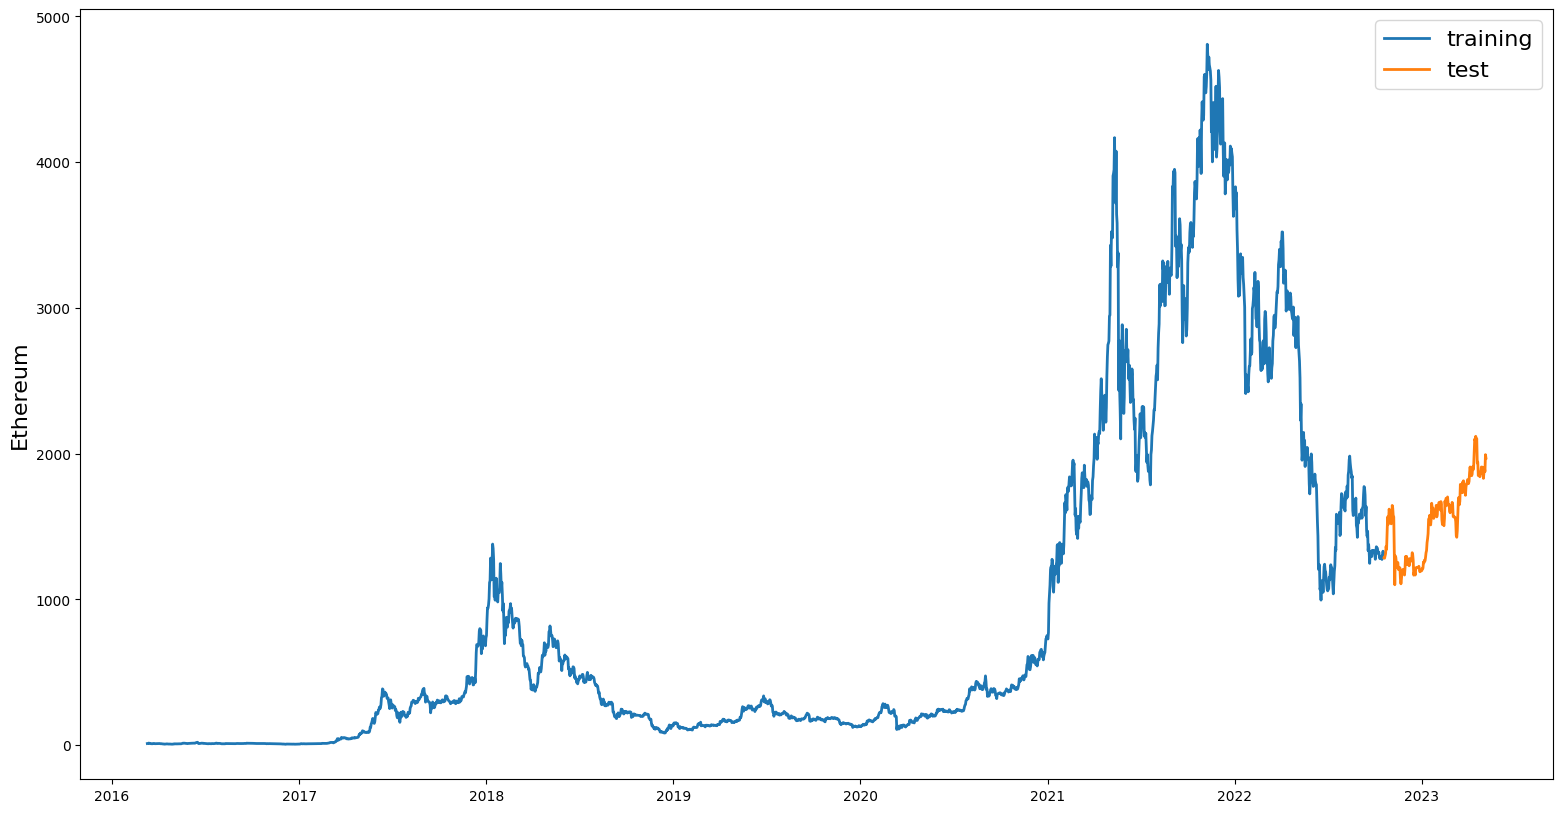

In [548]:
line_plot(train_data[aim], test_data[aim], 'training', 'testing', title='')